#### Lab 2, for 501
#### Merging and CLT

# Part I

### Package loading

In [11]:
#These are some package I load to do data analysis.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings

warnings.filterwarnings('ignore')

### Loading the datasets

In [5]:
vdem=pd.read_stata('vdem1.dta')
qog=pd.read_stata('qog1.dta')
median=pd.read_stata('medianvoter.dta')

### Droping Missing values

In [6]:
#Regression in Python cannot be done if the data has missing values.
#So before merging, I drop missing values from each datasets.

vdem.dropna(inplace=True)
qog.dropna(inplace=True)
median.dropna(inplace=True)

### Data Preprocessing

In [7]:
#in qog dataset the year variable is string. So, I tranform it into numeric. 
qog['year']=qog['year'].astype('int')

In [15]:
#I take variables I need from the turnout dataset.
#I slice the data so that I can understand what is going on easily when merging.
#I name new dataset as "med2"

med2=median[['natname', 'elecdate', 'turnout', 'elecsize']]

In [16]:
#Because the 'elecdate' variable is in year and month format,
#I first transform 'elecdate' variable into a 'string' variable.
#I assign a new name, which is 'elecyear'
med2['elecyear']=med2['elecdate'].astype('string')

#Then, I slice it up. Basically, I say take only first 4. No more last two digits. 
med2['elecyear']=med2["elecyear"].str.slice(0,4)

#So now, I no longer need 'elecdate' variable in my dataset. I created new one.
med2.drop('elecdate', axis=1, inplace=True)

#remember our new 'elecyear' is still string. Let's make it numeric again.
med2['elecyear']=med2['elecyear'].astype('int')

### Transformation of DV

In [17]:
#To find the percent of turnout, I divide turnout to elecsize and then multiply with 100.
#I add a new variable in our dataframe as 'turn_percent'

med2['turn_percent']= ((med2['turnout']/med2['elecsize'])*100)

### Med2 dataset transformation 

In [18]:
#This dataset is really mess in terms of observations. 
#We need to make the rows as one country given a spesific year turnout percent.
#So, I first group the data with pivot function.
#I set the name of the country and elecyear as index.
#Ths way, it will group the data as given one country in a spesific year.

med2=med2.pivot_table(index=['natname','elecyear'])

#I reset the index,
#meaning that after the grouping,
#I put the two variables back to the dataframe as I need them for merging. 
med2=med2.reset_index()

### Merge I (Vdem + QoG)

In [19]:
#I create a new dataframe from merged datasets, named as 'vq'.
#I merge the data on 'cowcode' and 'year'.
#Python asks me how to merge, I say take only matched 'inner' observations.

vq=pd.merge(vdem, qog, how='inner',on=['cowcode','year'])

### Merge II (vq + med2)

In [23]:
#I know that it is dangerous to merge on country name
#as they can have different carecter. However, it seems that on this dataset, it is safe.
#though I remember when you said us to use cowcode from the internet source for stata. :/ 

#So our final dataset is a combination of vq and med2. 
#I say again merge only if they match.
#Merge them by looking the left dataset, which is vq, based on two variables, country and year.
#do the same with the right dataset in the code, 'med2' on natname and elecyear. 
#I do this because country and year are identical. 

finaldf=pd.merge(vq, med2, how='inner',
                 left_on=['country_x', 'year'],
                 right_on=['natname','elecyear'])

In [24]:
#After a succesful merge, lets drop all the colums that I do not need.
#I alread have year and name of the county, 
#and some variables that I am not interested.
finaldf.drop(['country_y','elecyear', 'natname','lifeex', 'popdens' ],
             axis=1, inplace=True)

### Save the final data (in case something happens)

In [25]:
finaldf.to_stata('finaldf.dta')

### Regression

In [27]:
#We are ready to regress!!!

#But first lets include another package for regression.
import statsmodels.api as sm

In [28]:
#This is my y variable. Dependent Variable.
y=finaldf['turn_percent']

In [29]:
#This is the independent variables for the first model,
#without female property rights
#I called it as x1.

x1=finaldf[['oppospower',
       'sepowerdist', 'gdpcap', 'youthunemp']]

In [30]:
#This is for our second model, with female property rights.
x2=finaldf[['propwomen','oppospower',
       'sepowerdist', 'gdpcap', 'youthunemp']]

In [31]:
#statsmodel does not have constant. So we add manually.
#Sorry to confuse you but, I assign our first model's IVs to 'x' now.
#x will contain all the IVs and constant now.
x=sm.add_constant(x1)

In [32]:
#I add constant to the second model as well.
#And name the IVs as x_withfemale.
x_withfemale=sm.add_constant(x2)

### Model I (Base model)

In [34]:
model1=sm.OLS(y,x).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           turn_percent   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     2.119
Date:                Mon, 08 Mar 2021   Prob (F-statistic):             0.0815
Time:                        21:53:45   Log-Likelihood:                -699.51
No. Observations:                 148   AIC:                             1409.
Df Residuals:                     143   BIC:                             1424.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          75.2472     15.935      4.722      0.000      43.749     106.745
oppospower    -11.0977      6.053     -1.833      0.069     -23.062       0.867
sepowerdist     7.9772      3.590      2.222      0.028       0.882      15.073
gdpcap       2.252e-05      0.000      0.139      0.889      -0.000       0.000
youthunemp      0.0220      0.271      0.081      0.935      -0.514       0.558
==============================================================================
Omnibus:                       32.907   Durbin-Watson:                   0.386
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.069
Skew:                          -1.354   Prob(JB):                     6.01e-11
Kurtosis:                       3.548   Cond. No.                     2.29e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model II (With Female Property Rights)

In [35]:
model2=sm.OLS(y,x_withfemale).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           turn_percent   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     4.844
Date:                Mon, 08 Mar 2021   Prob (F-statistic):           0.000403
Time:                        21:54:07   Log-Likelihood:                -692.11
No. Observations:                 148   AIC:                             1396.
Df Residuals:                     142   BIC:                             1414.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          44.8675     17.124      2.620      0.010      11.016      78.719
propwomen      24.2395      6.275      3.863      0.000      11.835      36.644
oppospower    -17.7388      6.029     -2.942      0.004     -29.656      -5.821
sepowerdist     2.7071      3.688      0.734      0.464      -4.584       9.998
gdpcap      -2.502e-05      0.000     -0.162      0.872      -0.000       0.000
youthunemp      0.0568      0.259      0.219      0.827      -0.455       0.569
==============================================================================
Omnibus:                       26.906   Durbin-Watson:                   0.404
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.011
Skew:                          -1.199   Prob(JB):                     1.51e-08
Kurtosis:                       3.299   Cond. No.                     2.54e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
#Finally let's put all the models together. #To make it nice on Latex. :) 

#Another package is needed!
#This package will produce latex format of these models.
from stargazer.stargazer import Stargazer

In [37]:
stargazer=Stargazer([model1,model2]) #put two models together

#give names to the models
stargazer.custom_columns(['Base Model', 'Spesified Model'], [1, 1])

#to show only two digit after the point in coeficents.
stargazer.significant_digits(2)

#to order the variables in the table.
#Put propwomen variable to the top and so on.

stargazer.covariate_order(['propwomen','oppospower', 
                           'gdpcap', 'sepowerdist',
                           'youthunemp','const'])

# Basically to rename the variables to make it more profesional as you said:) 
stargazer.rename_covariates({'const': 'Constant',
                             'oppospower':'Opposition Power',
                             'gdpcap': 'GDP($)',
                             'sepowerdist':'Class Political Power',
                             'youthunemp':'Unemployed Youth %',
                             'propwomen':'Female Property Rights'})

#that is just space formating.
stargazer.cov_spacing = 3

#let's print the final work that we can copy and past to tex studio.
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{2}{c}{\textit{Dependent variable:}} \
\cr \cline{2-3}
\\[-1.8ex] & \multicolumn{1}{c}{Base Model} & \multicolumn{1}{c}{Spesified Model}  \\
\\[-1.8ex] & (1) & (2) \\
\hline \\[-1.8ex]
 Female Property Rights & & 24.24$^{***}$ \\
  & & (6.28) \\
 Opposition Power & -11.10$^{*}$ & -17.74$^{***}$ \\
  & (6.05) & (6.03) \\
 GDP($) & 0.00$^{}$ & -0.00$^{}$ \\
  & (0.00) & (0.00) \\
 Class Political Power & 7.98$^{**}$ & 2.71$^{}$ \\
  & (3.59) & (3.69) \\
 Unemployed Youth % & 0.02$^{}$ & 0.06$^{}$ \\
  & (0.27) & (0.26) \\
 Constant & 75.25$^{***}$ & 44.87$^{***}$ \\
  & (15.93) & (17.12) \\
\hline \\[-1.8ex]
 Observations & 148 & 148 \\
 $R^2$ & 0.06 & 0.15 \\
 Adjusted $R^2$ & 0.03 & 0.12 \\
 Residual Std. Error & 27.79(df = 143) & 26.53(df = 142)  \\
 F Statistic & 2.12$^{*}$ (df = 4.0; 143.0) & 4.84$^{***}$ (df = 5.0; 142.0) \\
\hline
\hline \\[-1.8ex]
\textit{Note

# Part II

In [38]:
#Lets first include some visualization and a statistics packages

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statistics as stat

### Loading the dataset

In [40]:
#This our dataframe.
df=pd.read_stata('grade_clean.dta')

In [41]:
#i take the finalgrade from the dataset
finalgrade=df['finalgrade']

### Looping through

In [42]:
#I define a function which has a loop inside.
#Create a function called 'sample_mean_calculator' and
#take two parameters: the data and sample size.
#create a empty list called sample means first.
#then for each value in sample size, do followings:
#First create a sample variable which takes samples from the final grade.
#I set replace true because we want to use whole dataset again
#when we take another sample.
#then take the mean of samples from finalgrade and append to our empty list above.
#Do all things and return sample means for us. 
def sample_mean_calculator(data, n_samples):
    sample_means=[]
    for i in range(n_samples):
        sample=finalgrade.sample(n_samples, replace=True)
        sample_mean=stat.mean(sample)
        sample_means.append(sample_mean)
    return sample_means

### Plotting

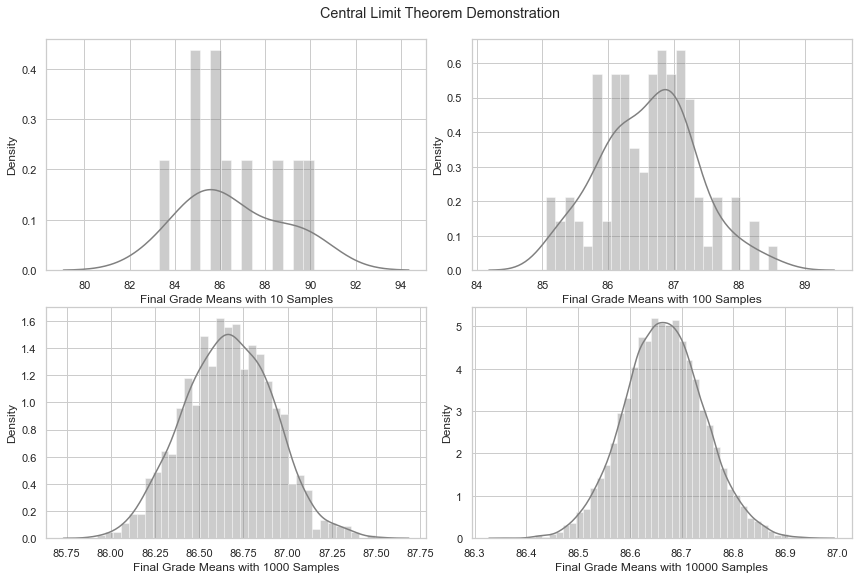

In [47]:
#These are some setting for making the graph nicer.
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(12,8))
fig.suptitle('Central Limit Theorem Demonstration')
plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
ax[0,0].set_xlabel('Final Grade Means with 10 Samples')
ax[0,1].set_xlabel('Final Grade Means with 100 Samples')
ax[1,0].set_xlabel('Final Grade Means with 1000 Samples')
ax[1,1].set_xlabel('Final Grade Means with 10000 Samples')

#lets plot
sns.distplot(ax=ax[0,0],x=sample_mean_calculator(finalgrade, 10),bins=15,color='gray')
sns.distplot(ax=ax[0,1],x=sample_mean_calculator(finalgrade, 100),bins=25,color='gray')
sns.distplot(ax=ax[1,0],x=sample_mean_calculator(finalgrade, 1000),bins=35,color='gray')
sns.distplot(ax=ax[1,1],x=sample_mean_calculator(finalgrade, 10000),bins=45,color='gray')
fig.savefig('Oner_CLT.png')
plt.show()